In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import utlis
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

In [3]:
import sys
PATH_TO_ROOT = 'C:\\Users\\kushs\\Downloads\\Electricity usage prediction\\Electricity usage prediction'
sys.path.insert(0,PATH_TO_ROOT)

In [4]:
def generate_fig_path(fig_name):
    
    return '{}/results/fig/tabular data model/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    
    return '{}/results/data/predict/{}.csv'.format(PATH_TO_ROOT, data_name)

In [5]:
def lightGBM_train(region, params):
    
    
    data = pd.read_csv(r'C:\Users\kushs\Downloads\Electricity usage prediction\Electricity usage prediction\results\data\{}_daily.csv'.format(region), index_col=0)
    data.index = pd.to_datetime(data.index) 
    data_lgmb = data[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 'Holiday', 'Weekend',
                      'Electricity demand, daily sum, (GWh)']]
    data_lgmb['Month'] = data_lgmb.index.month
    data_lgmb['dayOfWeek'] = data_lgmb.index.weekday
    data_lgmb = data_lgmb.dropna()

    
    data_train, data_test = utlis.prepare_data(data_lgmb, train_ratio=0.75)
    X_train = data_train[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 
                          'Holiday', 'dayOfWeek', 'Month']].values
    X_test = data_test[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 
                        'Holiday', 'dayOfWeek', 'Month']].values
    y_train = data_train['Electricity demand, daily sum, (GWh)'].values
    y_test = data_test['Electricity demand, daily sum, (GWh)'].values
    X_all = data_lgmb[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 
                       'Holiday', 'dayOfWeek', 'Month']].values
    
    d_train = lgb.Dataset(X_train, categorical_feature=[2,3,4], label=y_train)

    
    regr = lgb.train(params, d_train, 5000)
    
    rmse_train = mean_squared_error(regr.predict(X_train), y_train)**0.5
    rmse_test = mean_squared_error(regr.predict(X_test), y_test)**0.5
    print(f'-------City: {region}--------------')
    print(f'RMSE for Train: {rmse_train}')
    print(f'RMSE for Test: {rmse_test}')
    
    
    data_lgmb['yhat_lgbm'] = regr.predict(X_all)
    data_lgmb.index = data_lgmb['ds']
    data_lgmb.to_csv(generate_result_data_path(f'lgbm_{region}'), index=False)
    
    
    verif_plot = data_lgmb[['Electricity demand, daily sum, (GWh)','yhat_lgbm']]
    verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
                               'yhat_lgbm':'yhat'}, inplace=True)
    verif_plot['train'] = False
    verif_plot.loc[data_train.ds, 'train'] = True
    
    return verif_plot

In [6]:
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'

params['num_leaves'] = 4
params['min_data_in_leaf'] = 30
params['max_depth'] = 5

In [7]:
mum_lgbm = lightGBM_train('mum', params)
hyd_lgbm = lightGBM_train('hyd', params)
delhi_lgbm = lightGBM_train('delhi', params)

C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lgmb['Month'] = data_lgmb.index.month
C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lgmb['dayOfWeek'] = data_lgmb.index.weekday
C:\Users\kushs\anaconda3\envs\Time_series\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 5
[LightGBM] [Info] Start training from score 77.902280
-------City: mum--------------
RMSE for Train: 3.106568092672345
RMSE for Test: 6.95903945985008
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 1434, number of used features: 5
[LightGBM] [Info] Start training from score 47.838386


C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

-------City: hyd--------------
RMSE for Train: 1.9961755754069206
RMSE for Test: 3.2748478096560656
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1434, number of used features: 5
[LightGBM] [Info] Start training from score 434.721001


C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

-------City: delhi--------------
RMSE for Train: 14.056190223913324
RMSE for Test: 25.359409517105988


C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
C:\Users\kushs\AppData\Local\Temp\ipykernel_5904\3495497342.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False


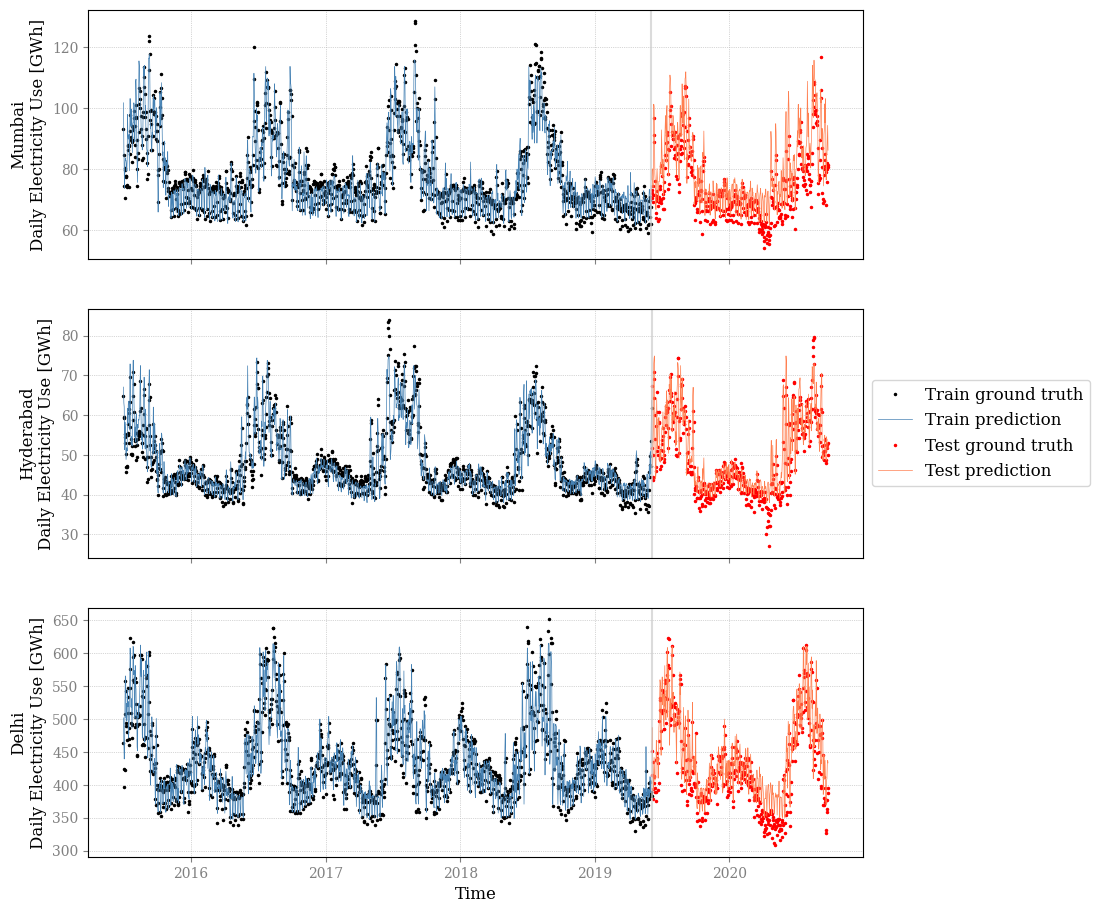

In [8]:
data_all = [mum_lgbm, hyd_lgbm, delhi_lgbm]
cities = ['Mumbai', 'Hyderabad', 'Delhi']

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

for index in range(3):
    data = data_all[index]
    city = cities[index]
    
    train = data[data['train']]
    axes[index].plot(train.index, train.y, 'ko', markersize=1.5, label='Train ground truth')
    axes[index].plot(train.index, train.yhat, color='steelblue', lw=0.5, label='Train prediction')
    test = data[data['train'] == False]
    axes[index].plot(test.index, test.y, 'ro', markersize=1.5, label='Test ground truth')
    axes[index].plot(test.index, test.yhat, color='coral', lw=0.5, label='Test prediction')

    axes[index].axvline(data[data['train']].index[-1], color='0.8', alpha=0.7)
    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure 14'))